# Naïve Bayes Classifier with Single Test Instance
This section will cover the implementation of the Naïve Bayes classifier where the entire dataset is used for training, and a new instance is used for testing.

Confusion Matrix:
 [[1 1]
 [0 1]]
Precision: 0.50
Recall: 1.00
Accuracy: 0.67
Prediction for new instance (Age: 'Young', Income: 'Medium'): Yes


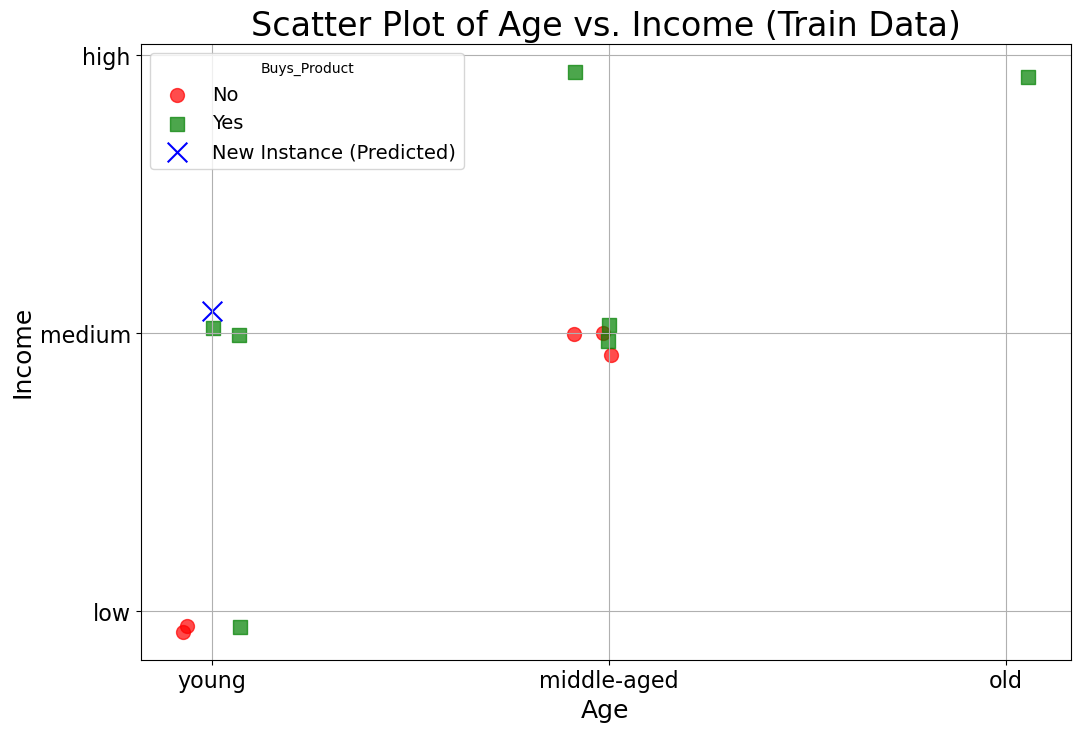

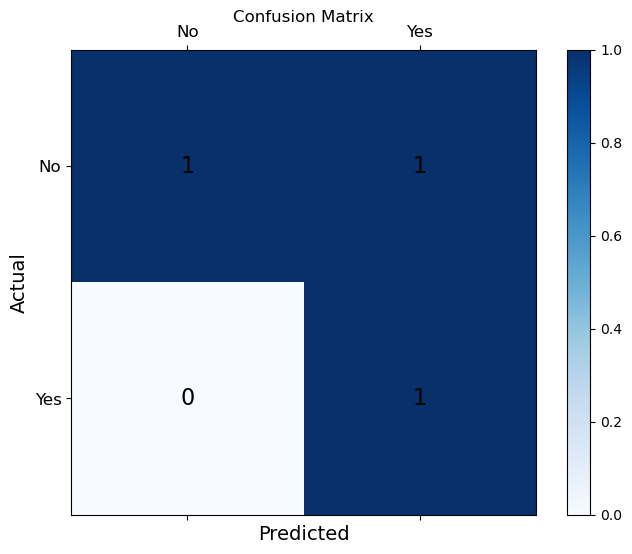

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
file_path = 'naive_bayes_data.csv'
data = pd.read_csv(file_path)

# Convert 'Buys_Product' to numerical for coloring and modeling
data['Buys_Product_Numeric'] = data['Buys_Product'].apply(lambda x: 1 if x == 'Yes' else 0)

# Mapping categorical values for 'Age' and 'Income'
age_mapping = {'young': 1, 'middle-aged': 2, 'old': 3}
income_mapping = {'low': 1, 'medium': 2, 'high': 3}

# Map the categorical values for 'Age' and 'Income'
data['Age_Mapped'] = data['Age'].map(age_mapping)
data['Income_Mapped'] = data['Income'].map(income_mapping)

# Split the data into 80% train and 20% test with a different random seed
np.random.seed(2) 
shuffled_indices = np.random.permutation(len(data))
train_size = int(len(data) * 0.8)
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]

train_data = data.iloc[train_indices].copy()  
test_data = data.iloc[test_indices].copy() 

# Apply jitter for better visualization
jitter_strength = 0.1
train_data.loc[:, 'Age_Jittered'] = train_data['Age_Mapped'] + np.random.uniform(-jitter_strength, jitter_strength, size=train_data.shape[0])
train_data.loc[:, 'Income_Jittered'] = train_data['Income_Mapped'] + np.random.uniform(-jitter_strength, jitter_strength, size=train_data.shape[0])
test_data.loc[:, 'Age_Jittered'] = test_data['Age_Mapped'] + np.random.uniform(-jitter_strength, jitter_strength, size=test_data.shape[0])
test_data.loc[:, 'Income_Jittered'] = test_data['Income_Mapped'] + np.random.uniform(-jitter_strength, jitter_strength, size=test_data.shape[0])

# Function to calculate class probabilities with Laplace smoothing
def calculate_class_probabilities(X, y, alpha=1):
    classes = np.unique(y)  # Get unique classes (0 and 1)
    class_probabilities = {}  # Dictionary to store class probabilities
    for cls in classes:
        class_data = X[y == cls]
        class_prob = len(class_data) / len(X)  # Prior probability P(y=k)
        feature_probs = {}
        for column in class_data.columns:
            value_counts = class_data[column].value_counts()
            total_count = len(class_data)
            smoothed_probs = (value_counts + alpha) / (total_count + alpha * len(value_counts))
            feature_probs[column] = smoothed_probs.to_dict()
        class_probabilities[cls] = {'class_prob': class_prob, 'feature_probs': feature_probs}
    return class_probabilities

# Function to predict the class for a new instance
def predict(new_instance, class_probabilities):
    best_label, best_prob = None, -1
    for cls, probs in class_probabilities.items():
        class_prob = probs['class_prob']
        feature_probs = probs['feature_probs']
        total_prob = class_prob
        for feature in new_instance.columns:
            value = new_instance[feature].values[0]
            if value in feature_probs[feature]:
                total_prob *= feature_probs[feature][value]
            else:
                total_prob *= 1e-6  # Smoothing for unseen features
        if best_label is None or total_prob > best_prob:
            best_prob = total_prob
            best_label = cls
    return best_label

# Calculate the class probabilities from the training data
X_train = train_data[['Age', 'Income']]
y_train = train_data['Buys_Product_Numeric']
class_probabilities = calculate_class_probabilities(X_train, y_train)

# Predict the class for the test data
X_test = test_data[['Age', 'Income']]
y_test = test_data['Buys_Product_Numeric']
y_pred = X_test.apply(lambda x: predict(pd.DataFrame([x]), class_probabilities), axis=1)

# Calculate confusion matrix, precision, recall, and accuracy
conf_matrix = np.zeros((2, 2), int)
for true, pred in zip(y_test, y_pred):
    conf_matrix[true, pred] += 1

tn, fp, fn, tp = conf_matrix.ravel()
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("Confusion Matrix:\n", conf_matrix)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# New instance for prediction
new_instance = pd.DataFrame({
    'Age': ['Young'], 
    'Income': ['Medium']
})

new_instance_mapped = {'Age_Mapped': age_mapping[new_instance['Age'][0].lower()], 'Income_Mapped': income_mapping[new_instance['Income'][0].lower()]}
new_instance_jittered = {'Age_Jittered': new_instance_mapped['Age_Mapped'] + np.random.uniform(-jitter_strength, jitter_strength),
                         'Income_Jittered': new_instance_mapped['Income_Mapped'] + np.random.uniform(-jitter_strength, jitter_strength)}

# Predict the class for the new instance
predicted_class = predict(new_instance, class_probabilities)
new_instance['Buys_Product_Predicted'] = 'Yes' if predicted_class == 1 else 'No'

# Print the prediction for the new instance
print(f"Prediction for new instance (Age: 'Young', Income: 'Medium'): {new_instance['Buys_Product_Predicted'].values[0]}")

# Visualize the training data and the new instance prediction
plt.figure(figsize=(12, 8))
colors = {0: 'red', 1: 'green'}
markers = {0: 'o', 1: 's'}
labels = {0: 'No', 1: 'Yes'}
for label in labels:
    subset = train_data[train_data['Buys_Product_Numeric'] == label]
    plt.scatter(subset['Age_Jittered'], subset['Income_Jittered'], c=colors[label], marker=markers[label], label=labels[label], s=100, alpha=0.7)

# Plot the new instance on the scatter plot
plt.scatter(new_instance_jittered['Age_Jittered'], new_instance_jittered['Income_Jittered'], c='blue', marker='x', s=200, label='New Instance (Predicted)')

# Setting axis labels and ticks
plt.xlabel('Age', fontsize=18)
plt.ylabel('Income', fontsize=18)
plt.title('Scatter Plot of Age vs. Income (Train Data)', fontsize=24)
plt.legend(title='Buys_Product', fontsize=14)
plt.xticks([1, 2, 3], ['young', 'middle-aged', 'old'], fontsize=16)
plt.yticks([1, 2, 3], ['low', 'medium', 'high'], fontsize=16)
plt.grid(True)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='Blues', fignum=1)
plt.title('Confusion Matrix', pad=20)
plt.colorbar()
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks([0, 1], ['No', 'Yes'], fontsize=12)
plt.yticks([0, 1], ['No', 'Yes'], fontsize=12)
for (i, j), val in np.ndenumerate(conf_matrix):
    plt.text(j, i, f'{val}', ha='center', va='center', fontsize=16)
plt.show()
